# Model selection

Here is a small example on how to do Bayesian model selection.

## Step by step explanation

### Defining a model

To do model selection, we first need some models. A model, in the simplest case,
is just a callable which takes a single `dict` as input and returns a single `dict` as output. The keys of the input dictionary are the parameters of the model, the output
keys denote the summary statistics.
Here, the `dict` is passed as `parameters` and has the entry `x`, which denotes the mean of a Gaussian.
It returns the observed summary statistics `y`, which is just the sampled value.

In [1]:
%matplotlib inline
import os
import tempfile
import scipy.stats as st

import pyabc
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

# Define a gaussian model

sigma = .5

def model(parameters):
    # sample from a gaussian
    y = st.norm(parameters.x, sigma).rvs()
    # return the sample as dictionary
    return {"y": y}

For model selection we usually have more than one model.
These are assembled in a list. We
require a Bayesian prior over the models.
The default is to have a uniform prior over the model classes.
This concludes the model definition.

In [2]:
# We define two models, but they are identical so far
models = [model, model]

# However, our models' priors are not the same.
# Their mean differs.
mu_x_1, mu_x_2 = 0, 1
parameter_priors = [
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_1, sigma)),
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_2, sigma))
]

### Configuring the ABCSMC run

Having the models defined, we can plug together the `ABCSMC` class.
We need a distance function,
to measure the distance of obtained samples.

In [3]:
# We plug all the ABC options together
abc = pyabc.ABCSMC(
    models, parameter_priors,
    pyabc.PercentileDistance(measures_to_use=["y"]))

INFO:Sampler:Parallelizing the sampling on 4 cores.


### Setting the observed data

Actually measured data can now be passed to the ABCSMC.
This is set via the `new` method, indicating that we start
a new run as opposed to resuming a stored run (see the "resume stored run" example).
Moreover, we have to set the output database where the ABC-SMC run
is logged.

In [4]:
# y_observed is the important piece here: our actual observation.
y_observed = 1
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
history = abc.new(db_path, {"y": y_observed})

INFO:History:Start <ABCSMC(id=61, start_time=2021-02-03 11:25:56.482318)>


The `new` method returns a history object, whose id identifies the ABC-SMC run in the database.
We're not using this id for now.
But it might be important when you load the stored data or want
to continue an ABC-SMC run in the case of having more than one
ABC-SMC run stored in a single database.

In [5]:
print("ABC-SMC run ID:", history.id)

ABC-SMC run ID: 61


### Running the ABC

We run the `ABCSMC` specifying the epsilon value at which to terminate.
The default epsilon strategy is the `pyabc.epsilon.MedianEpsilon`.
Whatever is reached first, the epsilon or the maximum number allowed populations,
terminates the ABC run. The method returns a `pyabc.storage.History` object, which
can, for example, be queried for the posterior probabilities.

In [6]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.2, max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.5607233741155757
INFO:ABC:t: 0, eps: 0.5607233741155757.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.2118243083623574.
INFO:ABC:Acceptance rate: 100 / 420 = 2.3810e-01, ESS=9.0802e+01.
INFO:ABC:t: 2, eps: 0.09379499357217409.
INFO:ABC:Acceptance rate: 100 / 706 = 1.4164e-01, ESS=8.6851e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=61, duration=0:00:05.054580, end_time=2021-02-03 11:26:01.536898>


Note that the history object is also always accessible from the abcsmc object:

In [7]:
history is abc.history

True

The `pyabc.storage.History>` object can, for example,
be queried for the posterior probabilities in the populations:

In [8]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.340000,0.660000
1,0.311586,0.688414
2,0.246014,0.753986


And now, let's visualize the results:

<AxesSubplot:title={'center':'Model probabilities'}, xlabel='Population index', ylabel='Probability'>

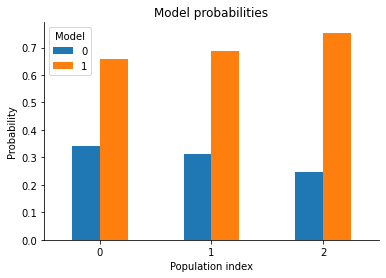

In [9]:
pyabc.visualization.plot_model_probabilities(history)

So model 1 is the more probable one. Which is expected as it was centered at 1 and the observed data was also 1, whereas model 0 was centered at 0, which is farther away from the observed data. 